# This notebook builds the density profile.
**Input** \
Dataset containing:
1) star location (ra, dec) \
2) the likelihood of each star being BHB. 
3) color of the star (to convert to absolute distance)

**Output** 
1) single power law index ($\alpha$) and normalization coefficient (A).\
2) visualizations of a mock dataset (generated from fitted density profile) stellar density distribution vs the actual data distribution \
3) BHB catalog (with removal of overdensities)

**For customized usage, modify the following variables.**

In [1]:
########### BASICS ############
# directories and files
import os
root_dir = '/home/jupyter-gracefq/Notebooks' 
input_data_path = os.path.join(root_dir, "data_with_probability.fits") # input data, assume '.fits' file
saved_data_path = os.path.join(root_dir,'BHB_catalog.fits') # directory to save the BHB catalog

saved_format = "fits" # data will be saved in '.fits' file

######## BHB Selection #########
# column names in the file
dm_name='distance_modulus' # distance modulus
d_name='d' # heliocentric distance
p_BHB_name = 'p_ml_BHB'
p_bhb_threshold = 0.5 # the threshold cut for BHB stars
g_band_name = 'wavg_mag_psf_g_dered' # g band magnitude, for completion cut

######## Density Profile #########
# name of the parameters (here we have 2)
parameter_names = [r'$\alpha$','A']


In [2]:

# import matplotlib and define our alias
from matplotlib import pyplot as plt

# plot figures within the notebook rather than externally
%matplotlib inline

# numpy
import numpy as np
from numpy.polynomial import polynomial as P


# scipy 
import scipy
from scipy.special import logsumexp
from scipy.optimize import minimize


from astropy.io import fits
from astropy.table import Table, MaskedColumn, Column


# Update font sizes
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    # Set tick direction to 'in' and tick size for both x and y axes
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,  # Adjust the size as needed
    'ytick.major.size': 5,   # Adjust the size as needed
    'axes.grid':False
})

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Data

In [3]:
# Visualize data
from astropy.table import vstack
filename=input_data_path
data = Table.read(filename, hdu=1).copy()


## 1.1 Distance Calibration

In [4]:
betw = lambda x, x1, x2: (x >= x1) & (x < x2)

# The following defines function to calibrate to absolute distances

def Mg_cal(gminusr):
    Mg = 0.398 - 0.392*(gminusr) + 2.729*(gminusr)**2 + 29.1128*(gminusr)**3 + 113.569*(gminusr)**4 
    return Mg

# converting from distance to distance modulus (dm) and vice versa
def d2dm(d):
    '''d in kpc'''
    return 5*np.log10(d*1000)-5

def dm2d(dm):
    '''d in kpc'''
    return 10**(dm/5.+1)/1000


def convert_to_distance(data):
    Mg = Mg_cal(data['gr'])
    # get distance module from apparent magnitude and absolute magnitude
    dm = data['wavg_mag_psf_g_dered'] - Mg
    d = dm2d(dm)
    t1 = Column(name='distance_modulus', data=dm)
    data.add_column(t1)
    t1 = Column(name='d', data=d)
    data.add_column(t1)
    return data



In [5]:
data = convert_to_distance(data)

## 1.3 Coordinate Transformation

Transformation of ra from (0,360) to (-180,180)


In [6]:
ra_transformed = [(ra-360) if ra>180 else ra for ra in data['ra']]

column = Column(name = "ra_transformed", data = ra_transformed)
data.add_column(column)

coordinates transform from (ra, dec,d) to (l,b,d)

In [7]:
# coordinates transform from (ra, dec,d) to (l,b,d)
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as coord
import astropy.units as u

# Define the coordinates of the star object
ra = data['ra'] * u.deg
dec = data['dec'] * u.deg
d = data['d'] * u.kpc

# Create a SkyCoord object with the equatorial coordinates
icrs = SkyCoord(ra=ra, dec=dec, distance=d, frame='icrs')

# Transform to Galactic coordinates
# Get the Galactic longitude (l), latitude (b), and distance (d) in appropriate units
galactic = icrs.transform_to(Galactic)
l = galactic.l*np.pi/180
b = galactic.b*np.pi/180
d = galactic.distance


# get the galactic radius
r = icrs.transform_to(coord.Galactocentric).spherical.distance
column = Column(name = "galactic_radius", data = r)
data.add_column(column)
column = Column(name = "l_rad", data = l)
data.add_column(column)
column = Column(name = "b_rad", data = b)
data.add_column(column)

b = galactic.b
column = Column(name = "b", data = b)
data.add_column(column)

## 1.4 BHB Probability Cut

In [8]:
new_data=data
# remove non-confident BHBs
threshold = 0.5
cut = new_data['p_ml_BHB'] > threshold
new_data = new_data[cut]
print(min(new_data['d']))
print(max(new_data['d']))
print(len(new_data))

8.93123367050083
117.58259920591784
9037


We can take a look at the spatial distribution our BHBs.

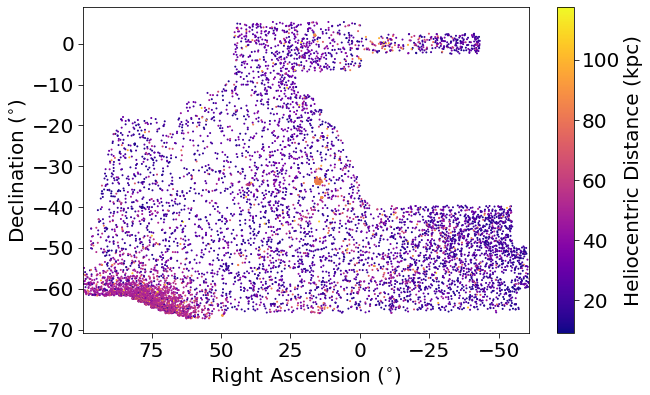

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(new_data['ra_transformed'], new_data['dec'], c=new_data['d'], cmap='plasma', s=1)
plt.xlim(max(new_data['ra_transformed']), min(new_data['ra_transformed']))
plt.xlabel(r'Right Ascension $(^{\circ})$')
plt.ylabel(r'Declination $(^{\circ})$')
plt.colorbar(label='Heliocentric Distance (kpc)')

Save the catalog as "BHB_catelog.fits"

In [10]:
new_data.write(saved_data_path, format = saved_format, overwrite=True)

We will remove the overdensities in the plot above.

## 1.5 Region Cut (Remove Overdensities)

Remove overdensities in Fornax, Sculptor, LMC, external galaxy, and Sgr. 

In [11]:
# We can add Sgr coordinate by converting (ra,dec) 

from transform_coordinates_to_sgr import Sagittarius

icrs = coord.SkyCoord(new_data['ra']*u.degree, new_data['dec']*u.degree, frame='icrs')
sgr = icrs.transform_to(Sagittarius)

Lambda, Beta = sgr.Lambda.value, sgr.Beta.value
Lambdashift = 360 - Lambda

column = Column(name = "Sgr_Lambda", data = Lambdashift)
new_data.add_column(column)
column = Column(name = "Sgr_Beta", data = Beta)
new_data.add_column(column)

In [12]:
# helper functions
from numpy import deg2rad, rad2deg, sin, cos, sqrt, arcsin

def sphdist(ra1, dec1, ra2, dec2):
    """measures the spherical distance in degrees
        The input has to be in degrees too
    """
    dec1_r = deg2rad(dec1)
    dec2_r = deg2rad(dec2)
    return 2 * \
           rad2deg \
                   (
                   arcsin
                       (
                       sqrt
                           (
                           (
                               sin((dec1_r - dec2_r) / 2)
                           ) ** 2
                           +
                           cos(dec1_r) * cos(dec2_r) *
                           (
                               sin((deg2rad(ra1 - ra2)) / 2)
                           ) ** 2
                       )
                   )
               )


def sphdist_fast(ra1, dec1, ra2, dec2):
    import numexpr
    return numexpr.evaluate(
        '2*57.295779513082323*(arcsin(sqrt((sin(0.017453292519943295*(dec1-dec2)/2))**2+cos(0.017453292519943295*dec1)*cos(0.017453292519943295*dec2)*(sin(0.017453292519943295*((ra1-ra2))/2))**2)))')



In [13]:
def region_cut(data):
    """ We will remove the overdensities in Sgr, Fornax, Sculptor, LMC, and an external galaxy. 
    """
    
    Sgrcoord_idx = np.abs(data["Sgr_Beta"]) < 20
    data = data[~Sgrcoord_idx] # remove stars whose absolute Sgr Beta coordinate < 20
    
    ra0,dec0 = 39.9583, -34.4997 #center for Fornax
    data['dist1'] = sphdist(data['ra'],data['dec'],ra0,dec0)
    cut1 = data['dist1'] <= 3 # only select stars with a distance > 5 deg from Fornax
    
    ra1,dec1 = 15.0183, -33.7186 #center for sculptor
    data['dist2'] = sphdist(data['ra'],data['dec'],ra1,dec1)
    cut2 = data['dist2'] <= 3 # only select stars with a distance > 5 deg from sculptor


    cut3 = (betw(data['dec'], -np.inf, -50) & betw(data['ra'], 50, 150)) # LMC
    cut=np.logical_not(np.logical_or(np.logical_or(cut1, cut3),cut2))
    data=data[cut]
    
    ra2, dec2 = 13.72291667, -37.68444444 # External galaxy
    data['dist3'] = sphdist(data['ra'], data['dec'], ra2, dec2)
    cut=data['dist3'] > 0.5
    data=data[cut]
    return data

In [14]:
# make the cut
data_with_overdensity = new_data
final_data=region_cut(data_with_overdensity)

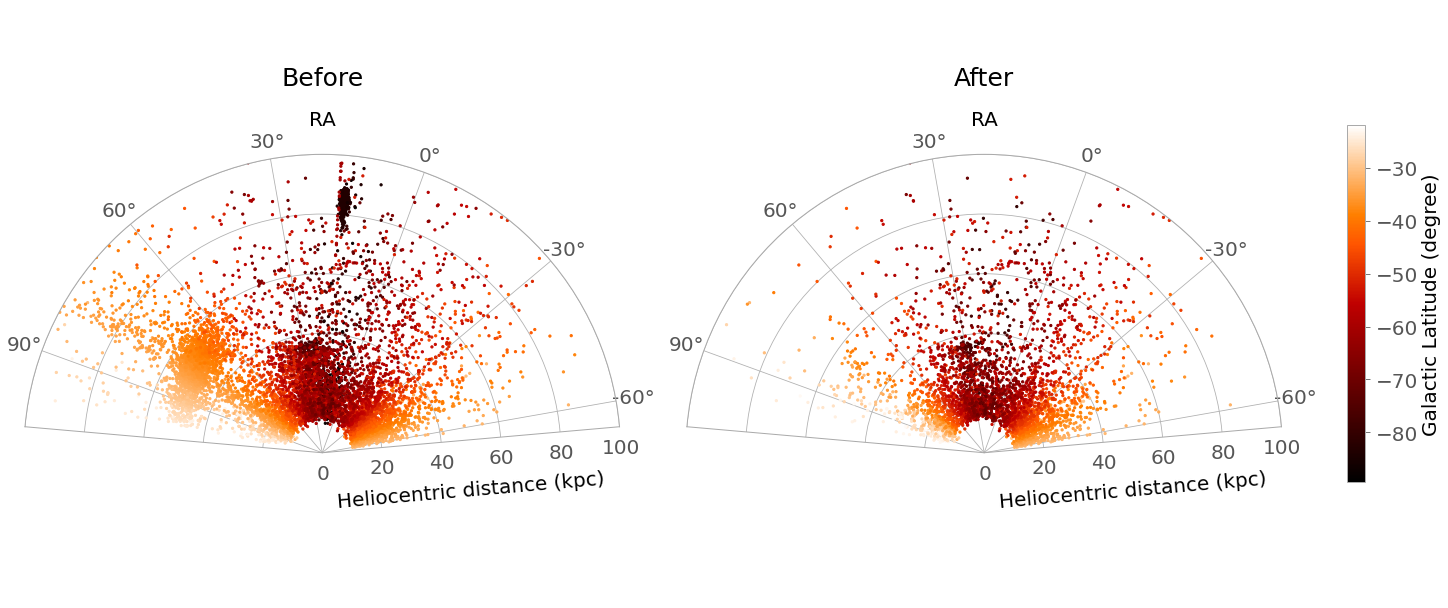

In [16]:
rotation_angle = -10
theta_min = -65
theta_max = 105

fig, (ax1, ax2) = plt.subplots(1,2,subplot_kw={'projection': 'polar'}, figsize=(20,10),layout='constrained')

# Before
theta = data_with_overdensity['ra']
distance = data_with_overdensity['d']
theta_rad = np.radians(theta)
im=ax1.scatter(theta_rad, distance,c=data_with_overdensity['b'], s=5, rasterized=True)
ax1.set_title("Before",y=0.85, pad=10)
ax1.set_ylim(0,100)
ax1.set_thetamin(theta_min)
ax1.set_thetamax(theta_max)
ax1.set_theta_zero_location('N', offset=-20)
label_position=ax1.get_rlabel_position()
ax1.text(250,ax1.get_rmax()/2.,'Heliocentric distance (kpc)',
        rotation=5,ha='center',va='top')

ax1.text(20/180*np.pi,ax1.get_rmax()+15,'RA',ha='center',va='top')

# After
theta = final_data['ra']
distance = final_data['d']
theta_rad = np.radians(theta)
im=ax2.scatter(theta_rad, distance, c=final_data['b'], vmin=min(new_data['b']), vmax=max(new_data['b']), s=5, rasterized=True)
ax2.set_ylim(0,100)
ax2.set_thetamin(theta_min)
ax2.set_title("After",y=0.85, pad=10)
ax2.set_thetamax(theta_max)
ax2.set_theta_zero_location('N', offset=-20)
label_position=ax2.get_rlabel_position()
ax2.text(250,ax2.get_rmax()/2.,'Heliocentric distance (kpc)',
        rotation=5,ha='center',va='top')
ax2.text(20/180*np.pi,ax2.get_rmax()+15,'RA',ha='center',va='top')
fig.colorbar(im,label='Galactic Latitude (degree)', shrink=0.5)
plt.savefig( './figures/BHB_radial_dist.pdf' , format='pdf', dpi=600, bbox_inches='tight')


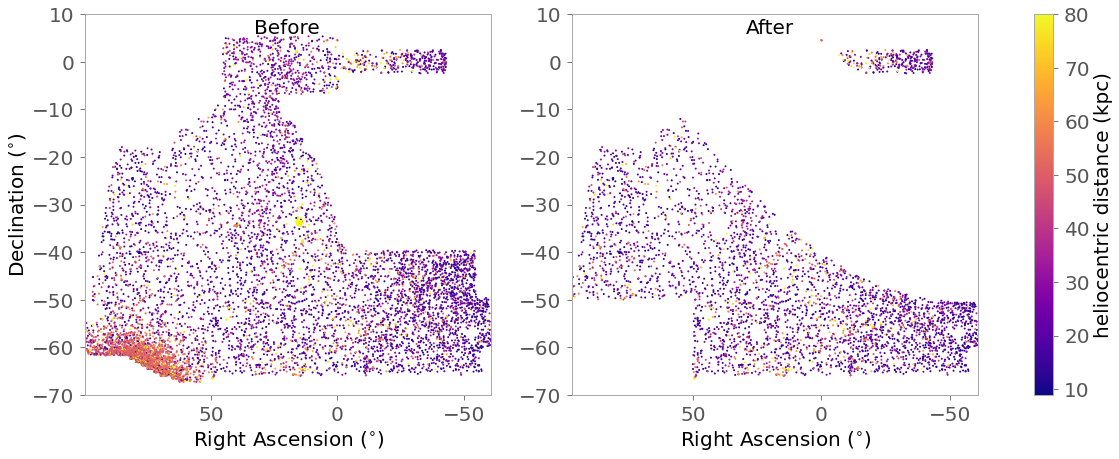

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Before
ax1 = axes[0]
ax1.text(20,6,'Before',fontsize=20,ha='center')
im1 = ax1.scatter(data_with_overdensity['ra_transformed'], data_with_overdensity['dec'], c=data_with_overdensity['d'], 
                  cmap='plasma', s=1, vmin=min(data_with_overdensity['d']), vmax=80, rasterized=True)
ax1.set_xlim(max(data_with_overdensity['ra_transformed']), min(data_with_overdensity['ra_transformed']))
ax1.set_ylim(-70,10)
ax1.set_xlabel(r'Right Ascension $(^{\circ})$')
ax1.set_ylabel(r'Declination $(^{\circ})$')

# After
ax2 = axes[1]
ax2.text(20,6,'After',fontsize=20,ha='center')
im2 = ax2.scatter(final_data['ra_transformed'], final_data['dec'], c=final_data['d'], s=1, cmap='plasma', 
                  vmin=min(data_with_overdensity['d']), vmax=80, rasterized=True)
ax2.set_xlim(max(final_data['ra_transformed']), min(final_data['ra_transformed']))
ax2.set_xlabel(r'Right Ascension $(^{\circ})$')
# ax2.set_ylabel(r'Declination $(^{\circ})$')
ax2.set_ylim(-70,10)

# Add colorbars
fig.colorbar(im2, ax=axes.ravel().tolist(), label='heliocentric distance (kpc)')
plt.savefig( './figures/BHB_spatial_dist.pdf' , format='pdf', dpi=600, bbox_inches='tight')


Text(62, 2, '$-40\\degree$')

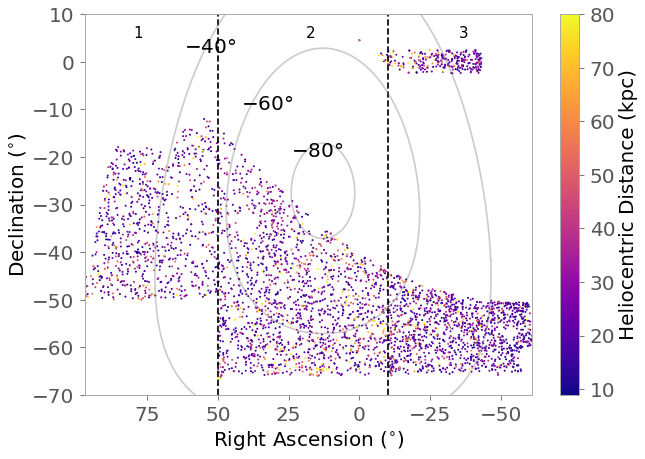

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))


# After
ax2 = axes
im2 = ax2.scatter(final_data['ra_transformed'], final_data['dec'], c=final_data['d'], s=1, 
                  cmap='plasma', vmin=min(data_with_overdensity['d']), vmax=80, rasterized=True)
ax2.set_xlim(max(final_data['ra_transformed']), min(final_data['ra_transformed']))
ax2.set_xlabel(r'Right Ascension $(^{\circ})$')
ax2.set_ylabel(r'Declination $(^{\circ})$')
fig.colorbar(im2, ax=ax2,label='Heliocentric Distance (kpc)')

plt.axvline(x=-10, color='k', linestyle='--')
plt.axvline(x=50, color='k', linestyle='--')
plt.text(80,5, '1', fontsize=15)
plt.text(19,5, '2',fontsize=15)
plt.text(-35,5, '3',fontsize=15)
ax2.set_ylim(-70,10)
# Add colorbars

# Plot lines of constant latitude:
longitude = np.arange(0,360.1,0.1)
lat0 = 0
lat20 = 20.0
latm20 = -20.0
lat40 = 40.0
latm40 = -40.0
lat60 = 60.0
latm60 = -60.0
lat80 = 80.0
latm80 = -80.0

sc0 = coord.SkyCoord(longitude*u.deg,lat0*u.deg,frame='galactic')
sc0_eq = sc0.icrs
# sc15 = coord.SkyCoord(longitude*u.deg,lat15*u.deg,frame='galactic')
# sc15_eq = sc15.icrs
sc20 = coord.SkyCoord(longitude*u.deg,lat20*u.deg,frame='galactic')
sc20_eq = sc20.icrs
sc40 = coord.SkyCoord(longitude*u.deg,lat40*u.deg,frame='galactic')
sc40_eq = sc40.icrs
sc60 = coord.SkyCoord(longitude*u.deg,lat60*u.deg,frame='galactic')
sc60_eq = sc60.icrs
sc80 = coord.SkyCoord(longitude*u.deg,lat80*u.deg,frame='galactic')
sc80_eq = sc80.icrs
# scm15 = coord.SkyCoord(longitude*u.deg,latm15*u.deg,frame='galactic')
# scm15_eq = scm15.icrs
scm20 = coord.SkyCoord(longitude*u.deg,latm20*u.deg,frame='galactic')
scm20_eq = scm20.icrs
scm40 = coord.SkyCoord(longitude*u.deg,latm40*u.deg,frame='galactic')
scm40_eq = scm40.icrs
scm60 = coord.SkyCoord(longitude*u.deg,latm60*u.deg,frame='galactic')
scm60_eq = scm60.icrs
scm80 = coord.SkyCoord(longitude*u.deg,latm80*u.deg,frame='galactic')
scm80_eq = scm80.icrs

# plot iso latitudes

plt.plot([(ra-360) if ra>180 else ra for ra in sc0_eq.ra.degree], sc0_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
# plt.plot([(ra-360) if ra>180 else ra for ra in sc15_eq.ra.degree], sc15_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
plt.plot([(ra-360) if ra>180 else ra for ra in sc20_eq.ra.degree], sc20_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
plt.plot([(ra-360) if ra>180 else ra for ra in sc40_eq.ra.degree], sc40_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
plt.plot([(ra-360) if ra>180 else ra for ra in sc60_eq.ra.degree], sc60_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
plt.plot([(ra-360) if ra>180 else ra for ra in sc80_eq.ra.degree], sc80_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
# plt.plot([(ra-360) if ra>180 else ra for ra in scm15_eq.ra.degree], scm15_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
# plt.plot([(ra-360) if ra>180 else ra for ra in scm20_eq.ra.degree], scm20_eq.dec, '.', color='Gray', markersize=0.4, alpha=0.4)
plt.plot([(ra-360) if ra>180 else ra for ra in scm40_eq.ra.degree], scm40_eq.dec, '-', color='Gray', markersize=0.8, alpha=0.4, label='b=-40')
plt.plot([(ra-360) if ra>180 else ra for ra in scm60_eq.ra.degree], scm60_eq.dec, '-', color='Gray', markersize=0.8, alpha=0.4, label='b=-60')
plt.plot([(ra-360) if ra>180 else ra for ra in scm80_eq.ra.degree], scm80_eq.dec, '-', color='Gray', markersize=0.8, alpha=0.4, label='b=-80')
plt.text(24, -20, r'$-80\degree$', color='k')
plt.text(42, -10, r'$-60\degree$', color='k')
plt.text(62, 2, r'$-40\degree$', color='k')

## 1.6 Other Substructures
Note that the cut above is not extensive -- there are other substructures left.

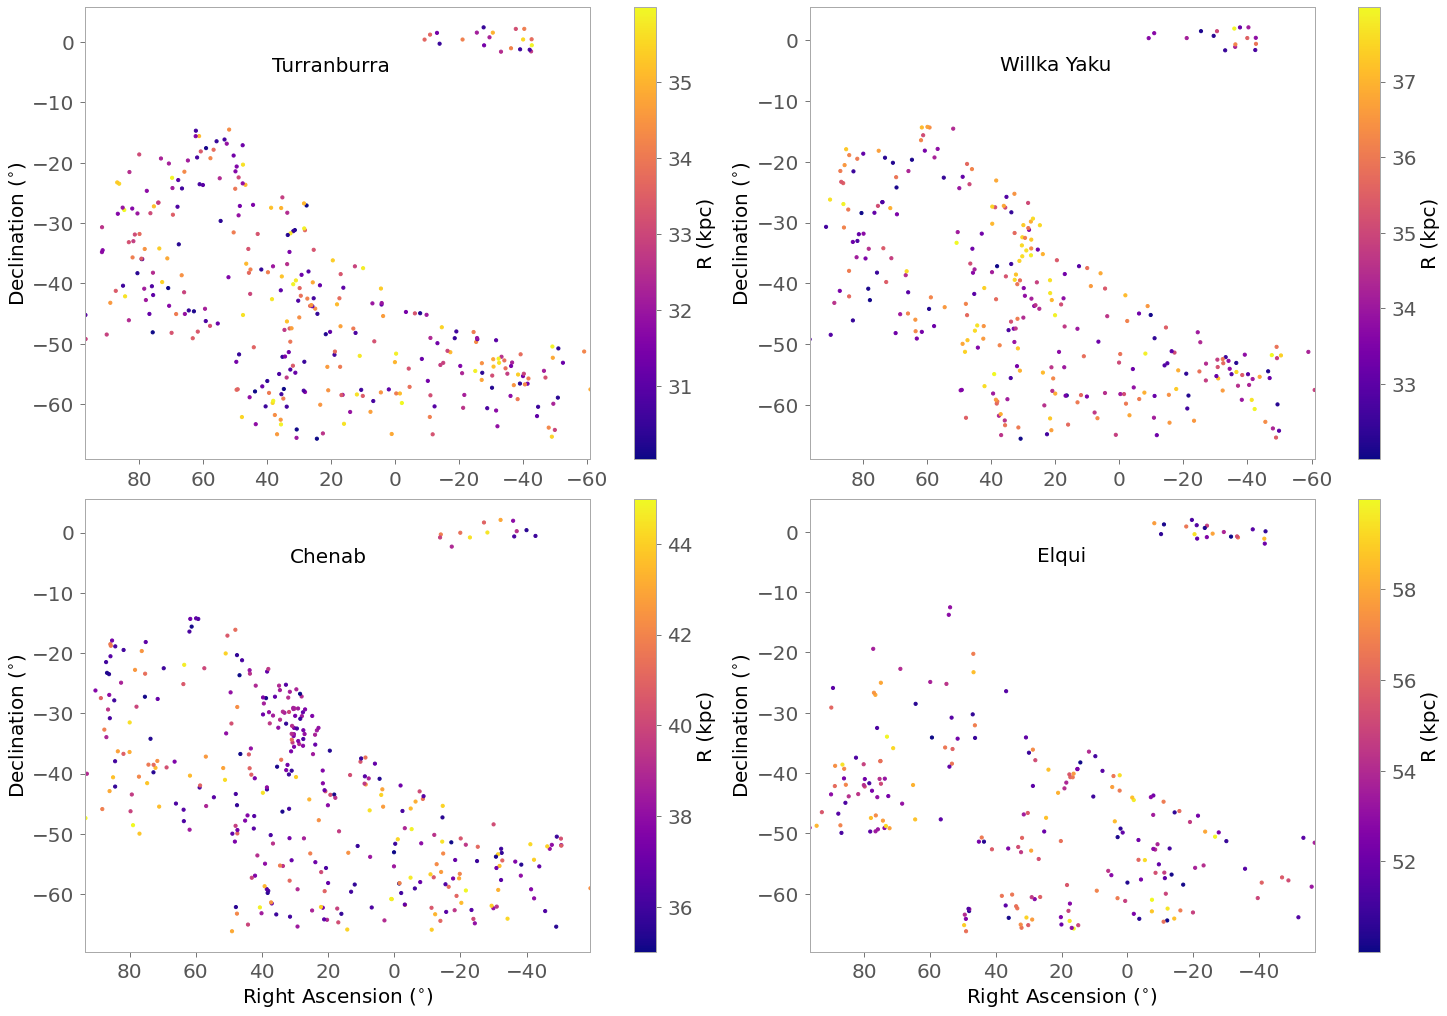

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), layout='constrained')
shift = 5

ax=axes[0,0]
ax.text(20, -5, 'Turranburra', fontsize=20, ha='center')
selected_data = final_data[betw(final_data['galactic_radius'], 30,36)]
im2 = ax.scatter(selected_data['ra_transformed'], selected_data['dec'], c=selected_data['galactic_radius'], s=10, cmap='plasma',rasterized=True)
ax.set_xlim(max(selected_data['ra_transformed']), min(selected_data['ra_transformed']))
# ax.set_xlabel(r'Right Ascension $(^{\circ})$')
ax.set_ylabel(r'Declination $(^{\circ})$')
fig.colorbar(im2, ax=ax,label='R (kpc)')


# second
ax=axes[0,1]
ax.text(20, -5, 'Willka Yaku', fontsize=20, ha='center')
selected_data = final_data[betw(final_data['galactic_radius'], 32,38)]
im2 = ax.scatter(selected_data['ra_transformed'], selected_data['dec'], c=selected_data['galactic_radius'], s=10, cmap='plasma',rasterized=True)
ax.set_xlim(max(selected_data['ra_transformed']), min(selected_data['ra_transformed']))
# ax.set_xlabel(r'Right Ascension $(^{\circ})$')
ax.set_ylabel(r'Declination $(^{\circ})$')
fig.colorbar(im2, ax=ax,label='R (kpc)')

# third
ax=axes[1,0]
ax.text(20, -5, 'Chenab', fontsize=20, ha='center')
selected_data = final_data[betw(final_data['galactic_radius'], 35,45)]
im2 = ax.scatter(selected_data['ra_transformed'], selected_data['dec'], c=selected_data['galactic_radius'], s=10, cmap='plasma',rasterized=True)
ax.set_xlim(max(selected_data['ra_transformed']), min(selected_data['ra_transformed']))
ax.set_xlabel(r'Right Ascension $(^{\circ})$')
ax.set_ylabel(r'Declination $(^{\circ})$')
fig.colorbar(im2, ax=ax,label='R (kpc)')

# fourth
ax=axes[1,1]
selected_data = final_data[betw(final_data['galactic_radius'], 50,60)]
ax.text(20, -5, 'Elqui', fontsize=20, ha='center')
im2 = ax.scatter(selected_data['ra_transformed'], selected_data['dec'], c=selected_data['galactic_radius'], s=10, cmap='plasma',rasterized=True)
ax.set_xlim(max(selected_data['ra_transformed']), min(selected_data['ra_transformed']))
ax.set_xlabel(r'Right Ascension $(^{\circ})$')
ax.set_ylabel(r'Declination $(^{\circ})$')
fig.colorbar(im2, ax=ax,label='R (kpc)')

plt.savefig( './figures/substructures.pdf' , format='pdf', dpi=600, bbox_inches='tight')


# 2. Density Profile

## 2. 1 Completion Cut
To establish an accurate density profile, it is important to account for potential partial selection effects at both the faint and bright extremes of the stellar populations. For example, at the brightest end where $g_{\mathrm{min}}=16$, it is possible that not all the stars with $g_{\mathrm{min}}$ are observed in DES DR2. \
The solution is through a completion cut: we compute all the possible heliocentric distances for stars with $g=g_{\mathrm{min}}$ and compute the maximum distance, which is 13.05 kpc. This distance is subsequently adopted as the lower limit $d_{\mathrm{min}}=13.05$ kpc. By excluding stars with distances below this threshold, we make sure that the remaining stars are complete in the bright end. 

In [20]:
data=final_data

In [21]:
# compute the max/min distance (assuming non-perfect completeness at bright/faint end)
cut = betw(data['wavg_mag_psf_g_dered'], 16, 20.5)
new_data=data[cut]
g_min, g_max = min(new_data['wavg_mag_psf_g_dered']),max(new_data['wavg_mag_psf_g_dered'])
possible_g_r_color = np.linspace(-0.35,-0.05,50)
possible_Mg = Mg_cal(possible_g_r_color)

# get distance module from apparent magnitude and absolute magnitude

# bright
possible_dm = g_min - possible_Mg
possible_d = dm2d(possible_dm)
print(f'At magnitude {g_min}, max possible distance is {max(possible_d):.4f}, min possible distance is {min(possible_d):.4f}')
cut1 = new_data['d'] > max(possible_d)

# faint
g_max =  20.49994659423828
possible_dm = g_max - possible_Mg
possible_d = dm2d(possible_dm)
print(f'At magnitude {g_max}, min possible distance is {min(possible_d):.4f}, max possible distance {max(possible_d):.4f}')
cut2 = new_data['d'] < min(possible_d)

cut = np.logical_and(cut1, cut2)
new_data = new_data[cut]
new_data = new_data[new_data['galactic_radius']>20]

At magnitude 16.000009536743164, max possible distance is 13.0528, min possible distance is 8.6079
At magnitude 20.49994659423828, min possible distance is 68.3726, max possible distance 103.6790


 We can show the resulting BHBs with respect to distances.

Text(0.5, 0, 'd (kpc)')

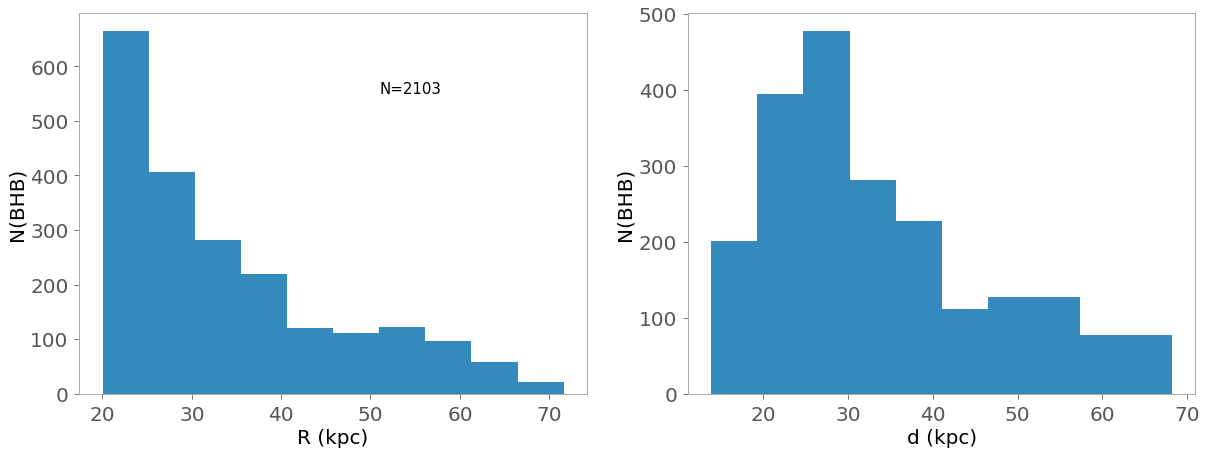

In [22]:
bins=10

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.hist(new_data['galactic_radius'], bins=bins)
# plt.title('BHB Count vs Galactocentric Distance')
plt.ylabel('N(BHB)')
plt.xlabel('R (kpc)')
plt.text(51,550, f'N={len(new_data)}',fontsize=15)
plt.subplot(1,2,2)
plt.hist(new_data['d'], bins=bins)
# plt.title('BHB Count vs Heliocentric Distance')
plt.ylabel('N(BHB)')
plt.xlabel('d (kpc)')


## 2.2 Fit the density function

We model the density profile by **inhomogeneous poisson point process**.
It is defined by 
$$  \lambda(l,b,d) =A\times d^2 \times cosb \times (R+R_{smooth}) ^{-\alpha_1} $$

<!-- $$  \lambda(l,b,d) =\begin{cases} A\times d^2 \times cosb \times (R+R_{smooth}) ^{-\alpha_1} & R < R_{break} \\
A \times \frac{(R_{break}+R_{smooth})^{-\alpha_1}}{(R_{break}+R_{smooth})^{-\alpha_2}}d^2 \times cosb \times (R+R_{smooth}) ^{-\alpha_2} & R \geq R_{break} 
\end{cases}
$$ -->

The **likelihood** of a BHB star appear at position **(l,b,d)** is defined as:
$$ \sum logL(l,b,d) = -\Lambda+ \sum log\lambda(l,b,d) = -\Lambda + \sum_1^N  logA+2logd +log(cosb) -\alpha_1 log(R+R_{smooth}) $$
<!-- $$ \sum logL(l,b,d) = -\Lambda+ \sum log\lambda(l,b,d) = -\Lambda + \sum_1^N \begin{cases}  logA+2logd +log(cosb) -\alpha_1 log(R+R_{smooth}) & R < R_{break} \\
logA+(\alpha_2 - \alpha_1)log(R_{break}+R_{smooth})+2logd +log(cosb) -\alpha_2 log(R+R_{smooth}) & R \geq R_{break} 
\end{cases}
$$ -->



   $$ \Lambda = \int_{d_{min}}^{d_{max}} \int_{0}^{2 \pi} \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} d^2 \cdot cos(b) \cdot (R+R_{smooth})^{-\alpha} \, db \, dl \, dd $$

So we have 2 parameters to fit: $$\alpha,  A$$

### 2.2.1 load pre-computed values and make interpolation
The precomputed integral values are stored in files ```precomputed_integral_values.txt```, which stores the precomputed ingetral $\Lambda$ values with different alpha values.

Here the integrals are evaluated at 50 evenly-distributed alpha values from 2 to 7. 
```alphas = np.linspace(2, 7, 50)```


In [23]:
r_0=8.3 # the distance from the Sun to the Galactic Center,
r_smooth = 1 # a smoothing radius to get around with the integral issue at 0

alphas = np.linspace(2, 7, 50)
interpolation = np.nan_to_num(np.loadtxt("./precomputed_integral_values.txt"))


In [24]:
from scipy.interpolate import PchipInterpolator

# We will interpolate the integral so that we can easily evaluate it given any alpha values
# Log is used for stability
interp1= PchipInterpolator(alphas, np.log(interpolation))


### 2.2.2 Dynesty

In [25]:
import dynesty
from schwimmbad import MultiPool

def log_likelihood(alpha_1,logA, l, b, d, galactic_r):
    """
    Compute the loglikelihood function of all stars. 
    """
    
    likelihood_1 = (logA + 2*np.log(d)+np.log(np.cos(b)) -alpha_1*np.log(galactic_r+r_smooth))
    integral1 = logA + interp1(alpha_1)

    return np.sum(likelihood_1)- np.exp(integral1) 

def loglike(theta, l = new_data['l_rad'], b = new_data['b_rad'], d = new_data['d'], galactic_r = new_data['galactic_radius']):
    """
    log-likelihood as a function of parameters `theta`.
    alpha_1, alpha2 = theta[0], theta[1]
    a, r_break = theta[2], theta[3]
    """
    # extract theta
    alpha_1 = theta[0]
    logA = theta[1]
    
    # evaluate loglikelihoods
    logl = log_likelihood(alpha_1, logA, l,b,d, galactic_r)
    return logl

def prior_transform(u):
    """
    Prior transform that takes a point u ~ [0, 1] and transforms it
    to the prior distribution of interest (i.e. the inverse CDF).
    """
    
    theta = np.copy(u)
    
    # alpha1 (2, 7)
    theta[0] = theta[0] * 5+2

    
    # logA = (1,16)
    theta[1] = theta[1] * 15 + 1


    return theta

# intialize sampler
nproc = 65
with MultiPool(nproc) as pool:
    sampler = dynesty.NestedSampler(loglike, prior_transform, 2, pool=pool)
    sampler.run_nested()


4941it [00:12, 410.63it/s, +500 | bound: 8 | nc: 1 | ncall: 23688 | eff(%): 23.465 | loglstar:   -inf < 2816.090 <    inf | logz: 2807.060 +/-  0.127 | dlogz:  0.001 >  0.509]


In [26]:
plt.rcdefaults()
# revert matplotlib to default settings

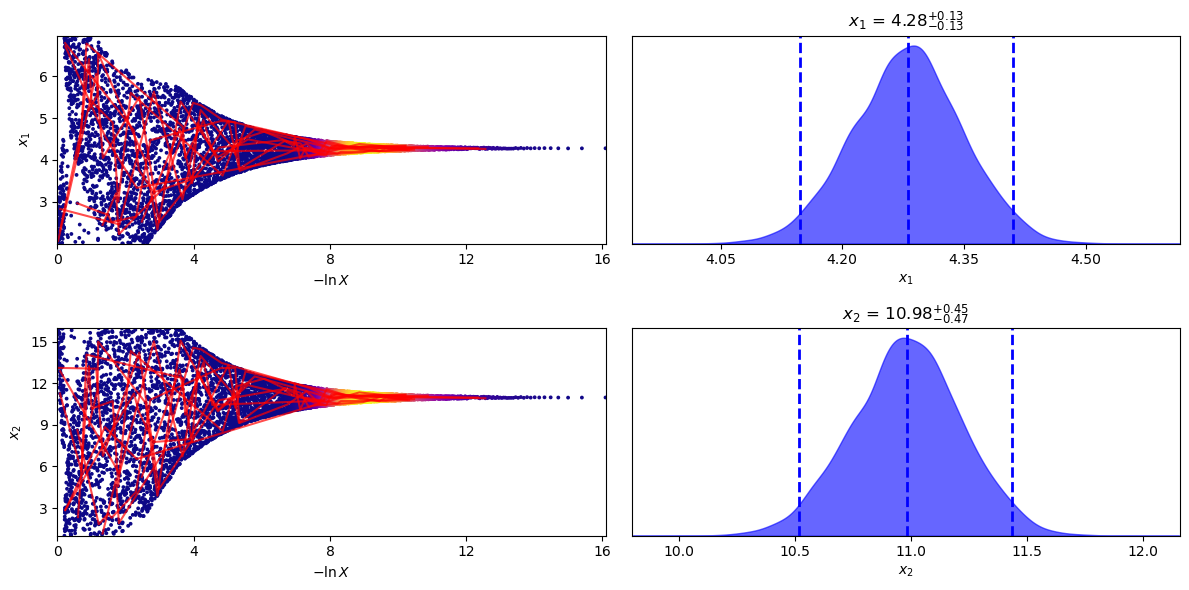

In [27]:
# save results
dres = sampler.results

from dynesty import plotting as dyplot
from dynesty import utils as dyutils

# plot sampling progress over time
fig, ax = dyplot.traceplot(dres, show_titles=True, connect=True)
plt.tight_layout()

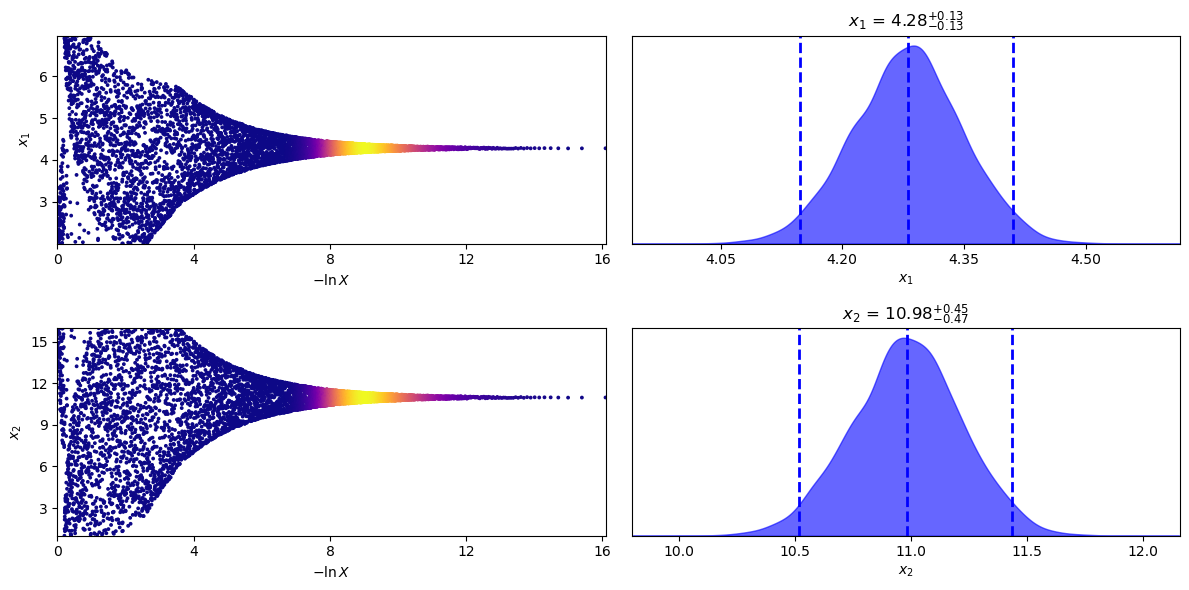

In [28]:
# plot sampling progress over time
fig, ax = dyplot.traceplot(dres, show_titles=True)
plt.tight_layout()

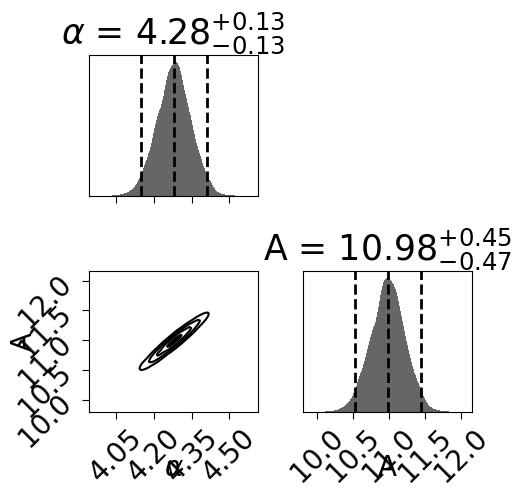

In [41]:
# 1 sigma
# fig, ax = dyplot.cornerplot(dres, labels = [r'$\alpha$', 'A'],show_titles=True, title_quantiles=(0.16,0.5,0.84))

# 2 sigmas
fig, ax = dyplot.cornerplot(dres, labels = [r'$\alpha$', 'A'],show_titles=True)
plt.tight_layout()
plt.savefig( './figures/single_law_corner_plot.pdf' , format='pdf', dpi=600, bbox_inches='tight')


### 2.2.3 Obtain the best result

In [30]:
# Save the best results
samp = dres.samples[-1]
print(dres.samples[-1])

# fitted values
alpha_inner, A = samp[0], np.exp(samp[1])

[ 4.27689041 10.96937216]


### 2.2.4 Mock Data Test
As a verification, we generate mock data from our best-fit parameters and compare the predicted stellar distribution with the actual distribution. To generate the predicted stellar distribution, we construct a grid of $l, b, d$ values. For each point $(l,b,d)$, we compute the density function $\lambda$ with the two selection functions $\mathbf{S}$, and record the distances $d, R$. Then We use the trapezoidal rule over the grid to compute the integral of densities $\lambda$. We normalize it so that it is equal to the total number of BHBs. Hence after normalization, the previously computed density $\lambda$ at different distances $d, R$ will approximate the predicted stellar count. 

As the selected BHB candidates are influenced by 1) the spatial coverage of the DES survey and 2) the limits on Galactocentric distances ($R$), they are not a true representation of the underlying stellar distributions. Hence when fitting the expected stellar distribution, we must consider these two selection effects.

These two considerations are already built in when precomputing the integral $\Lambda$ values. 

When generating mock data to compare with the actual distribution, we must also consider this. The following functions `survey_function` and `func` deals with this issue. For the details, you are welcome to check the paper.

In [31]:
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as coord
import astropy.units as u
betw = lambda x, x1, x2: (x >= x1) & (x < x2)

ra_min,ra_max,dec_min,dec_max = -60,100,-70,10 # approximate DES footprint coverage


def survey_function(l1, b1,ra_min,ra_max,dec_min,dec_max):
    galatic_coord = SkyCoord(l=l1*180/np.pi*u.deg, b=b1*180/np.pi*u.deg, frame='galactic')
    icrs_coord = galatic_coord.transform_to('icrs')
    ra,dec = icrs_coord.ra.to(u.deg), icrs_coord.dec.to(u.deg)
    if ra >180*u.deg:
        ra = (180*u.deg)-ra

    if ra <ra_min*u.deg or ra >ra_max*u.deg:
        return 0
    elif dec <dec_min*u.deg or dec >dec_max*u.deg:
        return 0
    else:
        return 1
    
    
def func(b,l,d, alpha):
    """Return the density given l,b,d."""
    return (d ** 2) * np.cos(b) * np.power(np.sqrt(r_0 ** 2 + d ** 2 - 2 * r_0 * d * np.cos(b) * np.cos(l)) + r_smooth,
                                           -1 * alpha) * (survey_function(l,b,ra_min,ra_max,dec_min,dec_max))


# get fitted function on grids of (l,b,d)
num_bins=15
n, bins, patches = plt.hist(new_data['d'], bins=num_bins)
plt.close()
bin_means = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)])

d_s = bin_means
n = 50
b_s = np.linspace(-0.5*np.pi, 0.5*np.pi, n+1)
l_s = np.linspace(0*np.pi, 2*np.pi, n+1)

dl = l_s[1]-l_s[0]
db = (b_s[1]-b_s[0])
densities_d = []
r_s = []
densities_r = []

for k in range(len(d_s)):
    density_d = []
    for i in range(len(l_s)):
        density = []
        for j in range(len(b_s)):
            radius = np.sqrt(r_0 ** 2 + d_s[k] ** 2 - 2 * r_0 * d_s[k] * np.cos(b_s[j]) * np.cos(l_s[i]))
            if radius < 20: # completion cut
                continue
            
            # store this for Galactorcentric density profile
            r_s.append(radius)
            densities_r.append(A*func(b_s[j], l_s[i], d_s[k], alpha_inner)) 
            
            # trapezoidal rule
            density.append(A*func(b_s[j], l_s[i], d_s[k], alpha_inner))
        density = np.sum(np.array(density)) * db # trapezoidal rule
        density_d.append(density)
    densities_d.append(np.sum(np.array(density_d)) * dl) # trapezoidal rule


bin_counts = np.array(densities_d)*(d_s[1]-d_s[0])# trapezoidal rule


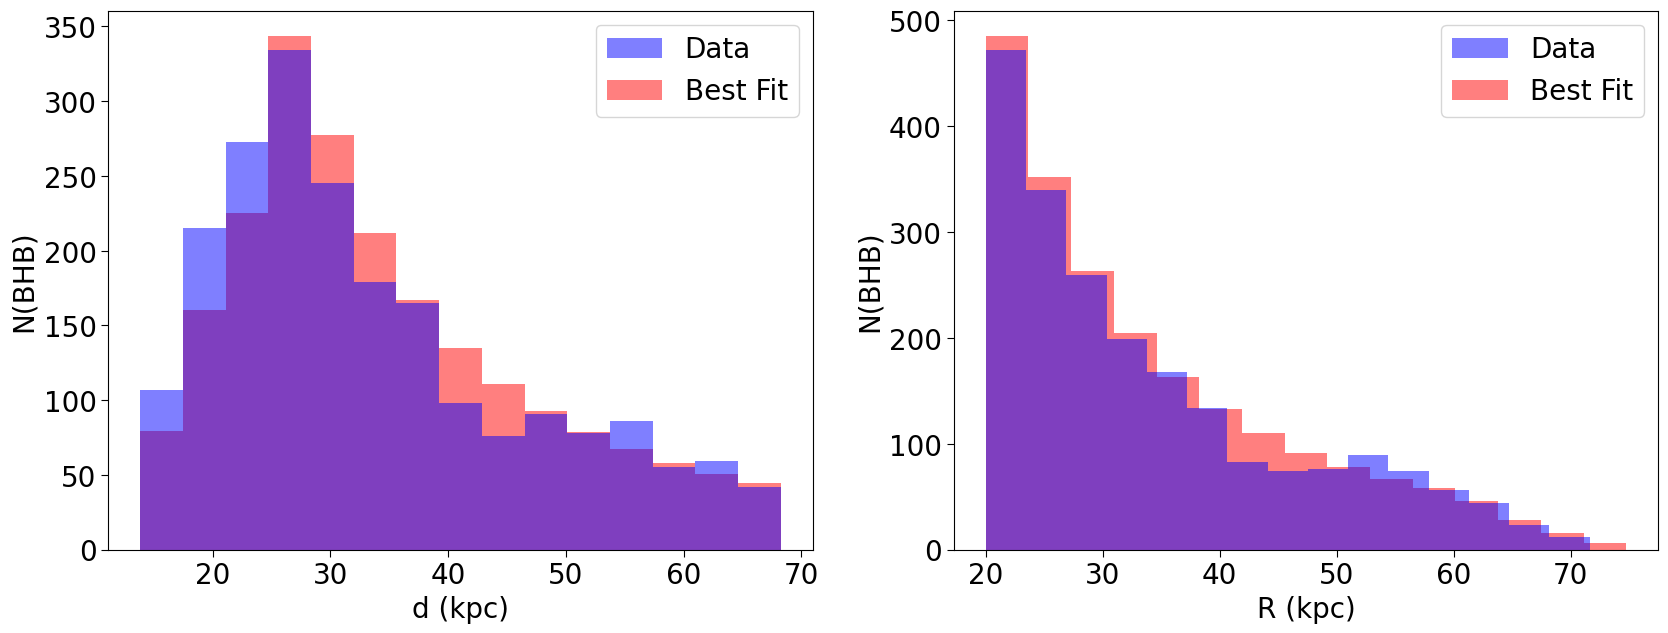

In [37]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
# Normarlize
bin_counts_normalized = bin_counts * (len(new_data) / sum(bin_counts))
# Plot the normalized histogram
plt.hist(new_data['d'], bins=num_bins, color='blue', alpha=0.5,zorder=1, label='Data', rasterized=True)
plt.bar(bin_means, bin_counts_normalized, width=(bins[1]-bins[0]),zorder=0,color='red',alpha=0.5, label=r'Best Fit', rasterized=True)
# plt.title(f"stellar count comparison")
plt.ylabel('N(BHB)')
plt.xlabel('d (kpc)')
plt.grid(False)
plt.legend()


plt.subplot(1,2,2)
densities_ = np.array(densities_r)
radius = np.array(r_s)
densities_ = densities_*len(new_data)/sum(densities_)
# plt.title(f"stellar count comparison")
plt.ylabel('N(BHB)')
plt.xlabel('R (kpc)')
plt.hist(new_data['galactic_radius'], bins=num_bins, color='blue', alpha=0.5,zorder=1, label='Data',rasterized=True)
plt.hist(radius, weights=densities_, bins=num_bins, color='red', alpha=0.5, zorder=0,label='Best Fit',rasterized=True)
plt.legend()
plt.grid(False)

plt.savefig( './mock_data.pdf' , format='pdf', dpi=600, bbox_inches='tight')




# 3. Literature Comparison

Obtain Literature Values.

In [38]:
alpha = [[1.70, 3.09, 4.58], [4.3], [2.3, 4.6], [2.1, 3.8], [4.24, 3.21], [2.70, 2.90], [4.40], [4.0], [3.51],[2.50,4.85], [4.17], [2.4,4.5], [2.54,5.42], [1.82, 4.14]]
alpha_uncertainty = [[0.16, 0.24, 0.10, 0.11, 0.10, 0.11], [1.2, 1.2], [], [0.3, 0.3, 0.1, 0.1], [0.8, 0.8, 0.7, 0.7], [0.01, 0.01, 0.11, 0.11], [0.05, 0.04], [0.1, 0.1], [0.36, 0.40],[0.04,0.04,0.04,0.04], [0.18,0.20], [], [0.09, 0.09, 0.13, 0.14], [0.08, 0.08, 0.05, 0.05]]
breaking_radius = [[11.85, 28.33], [], [27], [18], [41.4], [22], [], [], [],[19.4], [], [25], [32.1], [18.52]]
breaking_radius_uncertainty = [[0.92, 0.71, 1.05, 1.55], [], [], [1, 1], [2.5, 2.4], [], [], [], [],[0.4,0.4], [], [], [0.9, 1.1], [0.27, 0.27]]
notes = ['K-giant, bhb, rrl', 'exclude Sgr, heliod', 'galaticr', 'gaints,galaticr', 'bhb,galaticr', 'rrl', 'rrl', 'bhb', 'bhb,exclude GAMA15H and XMM-LSS','F stars (near-main sequence turnoff stars),near-MSTO','rrl','rrl','rrl', 'MSTO']
distance_range = [[5, 50], [50, 200], [0, 40], [10, 80], [15, 220], [1, 29], [20, 131], [10, 100], [50, 300],[10,60], [17,145], [5,115],[9,100], [0,60]]
papers = ['Han_2022', 'Deason_2018', 'Deason_2011', 'Xue_2015', 'Thomas_2018', 'Lorio_2018', 'Hernitschek_2018', 'Starkenburg_2019', 'Fukushima_2018','Pila-Díez_2015', 'Medina_2018', 'Watkins_2009', 'Stringer_2021', 'Pieres_2020']
colors = ['blue','green','olive','indigo','violet','teal','lime','aqua','grey','yellowgreen','yellow','pink','crimson','slategray']
star_categories = ['bhb,rrl,K-giant','bhb','bhb','bhb,rrl,K-giant','bhb','rrl', 'rrl','bhb','bhb', 'MSTO','rrl','rrl','rrl', 'MSTO']
line_categories = {'bhb,rrl,K-giant':'dashdot', 'bhb':'solid','rrl':'dotted','MSTO':'dashed'}
marker_categories={'bhb,rrl,K-giant':'D', 'bhb':'*','rrl':'+','MSTO':'s'}



In [39]:

# Corrected papers list
papers_old = ['Han_2022', 'Deason_2018', 'Deason_2011', 'Xue_2015', 'Thomas_2018', 'Lorio_2018', 'Hernitschek_2018', 'Starkenburg_2019', 'Fukushima_2018','Pila-Díez_2015', 'Medina_2018', 'Watkins_2009', 'Stringer_2021', 'Pieres_2020']
papers_new = ['Watkins_2009', 'Deason_2011', 'Xue_2015', 'Pila-Díez_2015', 'Deason_2018', 'Fukushima_2018', 'Hernitschek_2018', 'Lorio_2018', 'Medina_2018','Thomas_2018','Starkenburg_2019','Pieres_2020','Stringer_2021','Han_2022']

# Create a mapping from old indices to new indices
mapping = {papers_old.index(paper): papers_new.index(paper) for paper in papers_old}

# Function to reorder a list based on the mapping
def reorder_list(lst, mapping):
    if not lst:
        return []
    new_list = [None] * len(lst)
    for old_index, new_index in mapping.items():
        new_list[new_index] = lst[old_index]
    return new_list

# Reorder all lists
alpha = reorder_list(alpha, mapping)
alpha_uncertainty = reorder_list(alpha_uncertainty, mapping)
breaking_radius = reorder_list(breaking_radius, mapping)
breaking_radius_uncertainty = reorder_list(breaking_radius_uncertainty, mapping)
distance_range = reorder_list(distance_range, mapping)
colors = reorder_list(colors, mapping)

# The papers list is already in the new order, so we don't need to reorder it
papers = papers_new



Compare with our result by making a plot of alpha index as a function of distance.

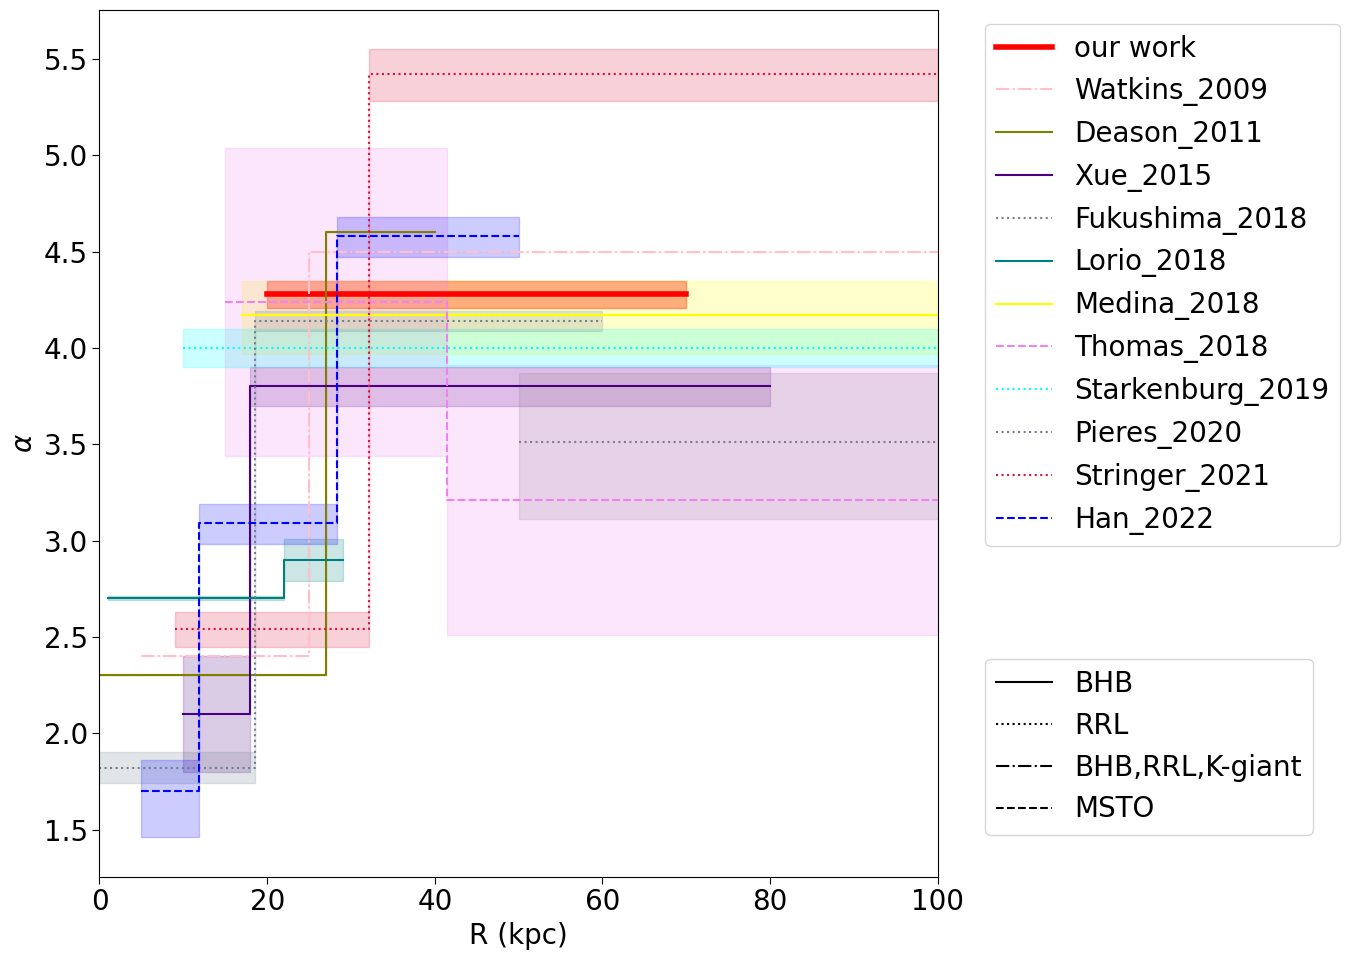

In [40]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot([20,70], [4.28,4.28],label='our work',color='red',linewidth=4)
ax.fill_between([20,70], [4.35,4.35], [4.21,4.21], alpha=0.4,zorder=0,color='red')

# Loop through the data to plot the lines
for i, (ranges, breakpoints, values, uncertainty, name) in enumerate(zip(distance_range, breaking_radius, alpha, alpha_uncertainty, papers)):
    if name in ["Deason_2018", "Pila-Díez_2015", "Hernitschek_2018"]:
        continue # skip deason since it's heliocentric
    x_range = ranges  # x-range of the line
    y_values = values  # y-values of the line
    
    x_breakpoints = [x_range[0]] + breakpoints + [x_range[1]]
    y_breakpoints = y_values 
    plotting_values = []
    y1 = []
    y2 = []
    x = []
    for j in range(len(y_breakpoints)):
        plotting_values.append(np.array([x_breakpoints[j], y_breakpoints[j]]))
        plotting_values.append(np.array([x_breakpoints[j+1], y_breakpoints[j]]))   
    plotting_values = np.array(plotting_values)
    for j in range(len(y_breakpoints)):
        if uncertainty:
            x.extend([x_breakpoints[j],x_breakpoints[j+1]])
            y1.extend([y_breakpoints[j]+uncertainty[2*j],y_breakpoints[j]+uncertainty[2*j]])
            y2.extend([y_breakpoints[j]-uncertainty[2*j+1],y_breakpoints[j]-uncertainty[2*j+1]])
        else:
            x.extend([x_breakpoints[j],x_breakpoints[j+1]])
            y1.extend([y_breakpoints[j],y_breakpoints[j]])
            y2.extend([y_breakpoints[j],y_breakpoints[j]]) 
    ax.fill_between(x, y1, y2, alpha=0.2,zorder=0,color=colors[i], rasterized=True)
    ax.plot(plotting_values[:,0], plotting_values[:,1], label=papers[i], 
            linestyle=line_categories[star_categories[i]],color=colors[i], rasterized=True)
    xgrid=np.linspace(plotting_values[:,0][0],plotting_values[:,0][1],10)
    ygrid = np.ones(10)*plotting_values[:,1][0]

# Set labels and title
ax.set_xlabel('R (kpc)')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,100)


# manually add a second legend
all_categories = ["bhb", "rrl","bhb,rrl,K-giant", "MSTO"]
plot_lines=[]
for i in range(len(all_categories)):
    l1, = plt.plot(5,5, linestyle=line_categories[all_categories[i]], color='k',rasterized=True)
    plot_lines.append(l1)
legend1 = plt.legend(plot_lines, ["BHB", "RRL","BHB,RRL,K-giant","MSTO"], bbox_to_anchor=(1.04, 0.15),loc="center left")
plt.gca().add_artist(legend1)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.grid(False)
# Show the plot
plt.savefig( './figures/literature_comparison.pdf' , format='pdf', dpi=600, bbox_inches='tight')
plt.show()


# Our Catalog

In [55]:
input_data_path = os.path.join(root_dir, "data_with_probability.fits") # input data, assume '.fits' file
data = Table.read(input_data_path, hdu=1).copy()
data = convert_to_distance(data)
data.columns

<TableColumns names=('coadd_object_id','tilename','hpix_32','hpix_64','hpix_1024','hpix_4096','hpix_16384','ra','dec','alphawin_j2000','deltawin_j2000','galactic_l','galactic_b','xwin_image','ywin_image','a_image','erra_image','b_image','errb_image','theta_j2000','errtheta_image','kron_radius','ebv_sfd98','mag_auto_g_dered','mag_auto_r_dered','mag_auto_i_dered','mag_auto_z_dered','mag_auto_y_dered','wavg_mag_psf_g_dered','wavg_mag_psf_r_dered','wavg_mag_psf_i_dered','wavg_mag_psf_z_dered','wavg_mag_psf_y_dered','extended_class_coadd','extended_class_wavg','flags_g','imaflags_iso_g','nepochs_g','flags_r','imaflags_iso_r','nepochs_r','flags_i','imaflags_iso_i','nepochs_i','flags_z','imaflags_iso_z','nepochs_z','flags_y','imaflags_iso_y','nepochs_y','xwin_image_g','xwin_image_r','xwin_image_i','xwin_image_z','xwin_image_y','ywin_image_g','ywin_image_r','ywin_image_i','ywin_image_z','ywin_image_y','x2win_image_g','x2win_image_r','x2win_image_i','x2win_image_z','x2win_image_y','y2win_image_

In [59]:
columns_to_keep = {
    'coadd_object_id': 'Object ID',
    'ra': 'RA',
    'dec': 'DEC',
    'wavg_mag_psf_g_dered': r'$g_0$',
    'wavg_mag_psf_r_dered': r'$r_0$',
    'wavg_mag_psf_i_dered': r'$i_0$',
    'wavg_mag_psf_z_dered': r'$z_0$',
    'd': 'Distance',
    'p_ml_BHB':r'$p_\mathrm{BHB}$',
    # Add more columns as needed
}

# Keep only the specified columns
selected_data = data[list(columns_to_keep.keys())].copy()

# Rename the columns
for old_col, new_col in columns_to_keep.items():
    selected_data[new_col] = selected_data[old_col]
    del selected_data[old_col]
    if new_col in ['RA', 'DEC']:
        # For the 'RA' "DEC" column, round to 6 decimal places
        selected_data[new_col] = selected_data[new_col].round(6)
    else:
        # For other columns, round to 2 decimal places
        selected_data[new_col] = selected_data[new_col].round(2)
    
# 1) View the first 10 rows
print("First 10 rows:")
selected_data[:10]


First 10 rows:


Object ID,RA,DEC,$g_0$,$r_0$,$i_0$,$z_0$,distance,$p_\mathrm{BHB}$
int64,float64,float64,float64,float64,float64,float64,float64,float64
994953737,345.969096,-42.549333,20.89,21.08,21.26,21.35,118.9,0.0
999753919,346.598197,-42.483844,19.32,19.54,19.73,19.78,56.18,0.95
999777071,346.818066,-42.73914,19.98,20.14,20.3,20.33,79.45,0.97
995168807,348.283024,-43.37528,17.19,17.5,17.74,17.84,17.53,0.98
998800330,347.896323,-43.028549,17.66,17.89,18.09,18.19,25.66,0.0
1001308502,349.326354,-43.156899,17.41,17.73,17.93,18.07,18.91,0.0
998795299,348.005177,-42.971495,20.24,20.36,20.5,20.6,90.63,0.0
998786086,347.917693,-42.875529,18.55,18.69,18.85,18.93,41.12,0.0
998773023,347.836941,-42.732092,17.52,17.66,17.82,17.89,25.72,0.0


In [61]:
# 2) Save the  data to CSV
selected_data.write('first_10_rows.tex')
csv_output_path = os.path.join(root_dir, "entire_catalog.csv")
selected_data.write(csv_output_path, format='csv', overwrite=True)
print(f"Data saved to {csv_output_path}")


Data saved to /home/jupyter-gracefq/Notebooks/entire_catalog.csv
